In [44]:
!pip install torch
!pip install einops
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install scikit-image

In [45]:
import numpy as np
import statistics
import os
from glob import glob
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
from einops.layers.torch import Rearrange
from einops import rearrange, repeat
import cv2 as cv
import matplotlib.pyplot as plt
import random
from skimage.metrics import structural_similarity


# 自定義圖像資料集類別

In [46]:
class CustomImage(Dataset):
    def __init__(self, img_folder, transform=None):
        super().__init__()
        self.img_folder = img_folder
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.ToTensor(),
            # transforms.Lambda(lambda x: (x - 0.5) * 2)
        ])
        self.image_paths = glob(os.path.join(img_folder, '*.png'))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv.imread(img_path)
        image = cv.resize(image, (128, 128))
        image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        if self.transform != None:
            image = self.transform(image)
        return image


# 取得資料加載器

In [47]:
def Get_DataLoader(dataset, DIP_Method=False):

    if DIP_Method == True:
        rand = random.randint(0, len(dataset) - 1)
        dataset = dataset[rand].view(1, 1, 128, 128)

    loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
    return loader


# 顯示圖像

In [48]:
def show_image(images, title=""):
    fig = plt.figure(figsize=(5, 5))

    if isinstance(images, torch.Tensor):
        if len(images.shape) == 4:
            # 將 CHW 格式的張量轉換為 HWC 格式
            images = rearrange(images, 'b c h w -> b h w c')
        elif len(images.shape) == 3:
            # 將 CHW 格式的張量轉換為 HWC 格式
            images = rearrange(images, 'c h w -> h w c')

        images = images.detach().cpu().numpy()

    if len(images.shape) == 4:
        s = math.ceil(len(images) ** 0.5)
        for idx in range(len(images)):
            ax = fig.add_subplot(s, s, idx + 1)
            ax.imshow(images[idx], cmap='gray')
            ax.axis('off')
    else:
        plt.imshow(images, cmap='gray')
        plt.axis('off')

    fig.suptitle(title, fontsize=20)
    plt.show()

# 第一批圖像

In [49]:
def show_first_batch(loader):
    for batch in loader:
        show_image(batch, 'Image in First batch')
        break


# 生成圖像

In [50]:
def generate_image(ddpm, n_samples=16, device=None, C=1, H=128, W=128):
    with torch.no_grad():
        if device is None:
            device = ddpm.device

        x = torch.randn(n_samples, C, H, W).to(device)

        if not ddpm.DIP_Method:
            for t in reversed(range(ddpm.n_steps)):
                time_T = (torch.ones(n_samples, 1) * t).to(device).long()
                eta_theta = ddpm.backward(x, time_T)

                alpha_t = ddpm.alphas[t]
                alpha_t_bar = ddpm.alpha_bars[t]

                x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

                if t > 0:
                    z = torch.randn(n_samples, C, H, W).to(device)
                    beta_t = ddpm.betas[t]
                    sigma_t = beta_t.sqrt()
                    x = x + sigma_t * z
        else:
            x = torch.cat([torch.randn(1, C, H, W).to(device) for _ in range(n_samples)], dim=0)
            x = ddpm.backward(x, None)

        return x

# 配置類設置

In [62]:
class config:
    batch_size: int = 8
    C: int = 1
    H: int = 128
    W: int = 128
    epochs: int = 500
    generate_interval: int = 50
    n_steps: int = 1000
    time_n_embd: int = 100
    min_beta: float = 0.0001
    max_beta: float = 0.02
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    image_path: str = "cat"
    lr: float = 0.002

# DDPM模型

In [52]:

class DDPM(nn.Module):

    def __init__(self, backward_=None, n_steps=100, device=None, min_beta=0.0001, max_beta=0.02, DIP_Method=False, time_step=True):
        super().__init__()
        self.image_shape = (1, 128, 128)
        if backward_ != None:
            self.backward_ = backward_.to(device)
        self.n_steps = n_steps
        self.device = device
        # get the tensor start with min_beta to max_beta with n_steps, [0.0001, ....., 0.02]
        self.betas = torch.linspace(min_beta, max_beta, self.n_steps).to(device)
        self.alphas = 1 - self.betas
        # alpha_bar_t = alpha_t * alpha_t-1 * ..... * alpha_1
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)
        self.DIP_Method = DIP_Method
        self.time_step = time_step

    def forward(self, x, t, eta=None):
        B, C, H, W = x.shape                                                    # batch_size, channel, height, width

        if self.time_step == True:

            alpha_bar = torch.tensor([self.alpha_bars[t]])                      # get current alpha_bar by current time_step
            alpha_bar = repeat(alpha_bar, 'C -> B C', B=B).to(self.device)      # repeat it B times(for batch calculation)

            # eta is a guassian distribution
            if eta == None:
                eta = torch.randn(B, C, H, W).to(self.device)

            # q = alpha_hat.sqrt() * x_0 + (1 - alpha_hat).sqrt() * eta
            noise = alpha_bar.sqrt().view(B, 1, 1, 1) * x.to(self.device) + (1 - alpha_bar).sqrt().view(B, 1, 1, 1) * eta

        else :
            noise = torch.randn(B, C, H, W)

        return noise

    def backward(self, x, t):
        # this is not the actual backpropagation, in DDPM we have forward(make noise) and backward(predict from noise)
        return self.backward_(x, t)



# 卷積神經網絡模塊

In [53]:
class Block(nn.Module):

    def __init__(self, shape, input_channel, output_channel, kernel_size=3, stride=1, padding=1, activation=True, normalize=True):
        super().__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is not None else nn.Identity()
        self.norm = normalize

    def forward(self, x):
        out = self.ln(x) if self.norm == True else x
        out = self.activation(self.conv1(out))
        out = self.activation(self.conv2(out))
        return out




# 正弦嵌入模塊

In [54]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, n, n_embd, theta=10000):
        super().__init__()
        self.emb_wei = self.create_sinusoidal_embeddings(n, n_embd, theta)
        self.embedding = nn.Embedding(n, n_embd)
        self.embedding.weight.data = self.emb_wei

    @staticmethod
    def create_sinusoidal_embeddings(n, n_embd, theta):
        emb_wei = torch.zeros(n, n_embd)
        positions = torch.arange(n).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, n_embd, 2) * (-torch.log(torch.tensor(theta)) / n_embd))
        emb_wei[:, 0::2] = torch.sin(positions * div_term)
        emb_wei[:, 1::2] = torch.cos(positions * div_term)
        return emb_wei

    def forward(self, x):
        return self.embedding(x)

# MLP模組

In [55]:
class MLP(nn.Module):

    def __init__(self, f_in, f_out):
        super().__init__()
        self.mlp_f = nn.Sequential(
            nn.Linear(f_in, f_out),
            nn.SiLU(),
            nn.Linear(f_out, f_out),
        )

    def forward(self, x):
        return self.mlp_f(x)

# **UNet 模型**

In [56]:
class UNet(nn.Module):

    def __init__(self, n_steps=1000, time_n_embd=100, DIP_Method=False):
        super().__init__()
        self.DIP_Method = DIP_Method

        # positional time embedding
        self.time_embd = SinusoidalPosEmb(n_steps, time_n_embd)

        # Down sampling
        self.time_emb1 = MLP(time_n_embd, 1)
        self.block1 = nn.Sequential(
            Block((1, 128, 128), 1, 10),
            Block((10, 128, 128), 10, 10),
            Block((10, 128, 128), 10, 10),
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.time_emb2 = MLP(time_n_embd, 10)
        self.block2 = nn.Sequential(
            Block((10, 64, 64), 10, 20),
            Block((20, 64, 64), 20, 20),
            Block((20, 64, 64), 20, 20),
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.time_emb3 = MLP(time_n_embd, 20)
        self.block3 = nn.Sequential(
            Block((20, 32, 32), 20, 40),
            Block((40, 32, 32), 40, 40),
            Block((40, 32, 32), 40, 40),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 3, 2, 1),
            nn.SiLU(),
        )

        # Bottleneck
        self.time_emb_mid = MLP(time_n_embd, 40)
        self.block_mid = nn.Sequential(
            Block((40, 16, 16), 40, 20),
            Block((20, 16, 16), 20, 20),
            Block((20, 16, 16), 20, 40),
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 3, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )

        self.time_emb4 = MLP(time_n_embd, 80)
        self.block4 = nn.Sequential(
            Block((80, 32, 32), 80, 40),
            Block((40, 32, 32), 40, 20),
            Block((20, 32, 32), 20, 20),
        )
        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)

        self.time_emb5 = MLP(time_n_embd, 40)
        self.block5 = nn.Sequential(
            Block((40, 64, 64), 40, 20),
            Block((20, 64, 64), 20, 10),
            Block((10, 64, 64), 10, 10),
        )
        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)

        self.time_emb_out = MLP(time_n_embd, 20)
        self.block_out = nn.Sequential(
            Block((20, 128, 128), 20, 10),
            Block((10, 128, 128), 10, 10),
            Block((10, 128, 128), 10, 10, normalize=False),
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        if self.DIP_Method == False:
            t = self.time_embd(t)
            N = len(x)
            out1 = self.block1(x + self.time_emb1(t).view(N, -1, 1, 1))
            out2 = self.block2(self.down1(out1) + self.time_emb2(t).view(N, -1, 1, 1))
            out3 = self.block3(self.down2(out2) + self.time_emb3(t).view(N, -1, 1, 1))

            out_mid = self.block_mid(self.down3(out3) + self.time_emb_mid(t).view(N, -1, 1, 1))

            out4 = torch.cat((out3, self.up1(out_mid)), dim=1)
            out4 = self.block4(out4 + self.time_emb4(t).view(N, -1, 1, 1))

            out5 = torch.cat((out2, self.up2(out4)), dim=1)
            out5 = self.block5(out5 + self.time_emb5(t).view(N, -1, 1, 1))

            out = torch.cat((out1, self.up3(out5)), dim=1)
            out = self.block_out(out + self.time_emb_out(t).view(N, -1, 1, 1))

            out = self.conv_out(out)

        else:
            # without time embedding
            out1 = self.block1(x)
            out2 = self.block2(self.down1(out1))
            out3 = self.block3(self.down2(out2))

            out_mid = self.block_mid(self.down3(out3))

            out4 = torch.cat((out3, self.up1(out_mid)), dim=1)
            out4 = self.block4(out4)

            out5 = torch.cat((out2, self.up2(out4)), dim=1)
            out5 = self.block5(out5)

            out = torch.cat((out1, self.up3(out5)), dim=1)
            out = self.block_out(out)
            out = self.conv_out(out)

        return out

# 評估DDPM效果

In [57]:
def eval_DDPM_Method(ddpm, origin_image):
    gen = generate_image(ddpm, n_samples=1)
    gen_np = gen.squeeze().cpu().numpy()  # Convert generated image tensor to numpy array
    origin_np = origin_image.squeeze().cpu().numpy()  # Convert original image tensor to numpy array

    # Calculate Structural Similarity Index (SSIM)
    sim = structural_similarity(gen_np, origin_np, data_range=1.0)

    print(f'Using SSIM get: {sim:.6f}')

# 評估不同學習率效果

In [58]:
def eval_lr(ddpms, learning_rates, origin_image, average_dict):
    gen_images = None

    for ddpm, lr in zip(ddpms, learning_rates):
        gen = generate_image(ddpm, n_samples=1)

        if gen_images is None:
            gen_images = gen
        else:
            gen_images = torch.cat((gen_images, gen), dim=0)

        gen_np = gen.squeeze().cpu().numpy()  # Convert generated image tensor to numpy array
        origin_np = origin_image.squeeze().cpu().numpy()  # Convert original image tensor to numpy array

        # Calculate Structural Similarity Index (SSIM)
        sim = structural_similarity(gen_np, origin_np, data_range=1.0)

        # Append similarity score to the corresponding learning rate key in average_dict
        average_dict[lr].append(sim)

    show_image(gen_images)

# 訓練深度動態預測模型（DDPM）

In [59]:
def train(ddpm, loader, epochs, optim, device, display=False):
    criterion = nn.L1Loss()
    n_steps = ddpm.n_steps
    losses = []
    gen_images = None
    for epoch in range(epochs):
        cur_loss = 0.0
        for step, batch in enumerate(loader):

            x0 = batch.to(device)
            if ddpm.DIP_Method == False:

                n = len(x0)
                eta = torch.randn_like(x0).to(device)
                t = torch.randint(0, n_steps, (n, )).to(device).view(n, -1)
                noise = ddpm(x0, t[0], eta)
                eta_theta = ddpm.backward(noise, t)

                loss = criterion(eta_theta, eta)

            else :
                n = len(x0)
                t = torch.randint(0, n_steps, (n, )).to(device).view(n, -1)
                noise = ddpm(x0, t[0]).to(device)
                # noise = ddpm(x0, None).to(device)
                gen = ddpm.backward(noise, None).to(device)
                loss = criterion(gen, x0)

            optim.zero_grad()
            loss.backward()
            optim.step()

            cur_loss += loss.item() * len(x0) / len(loader.dataset)

        losses.append(cur_loss)
        if epoch % 50 == 0:
            print(f'{epoch:3d} / {epochs:3d} loss : {cur_loss:.5f}')
            eval_DDPM_Method(ddpm, x0)

        if display == True and epoch % 50 == 0 :
            n_samples = 16 if ddpm.DIP_Method == False else 1
            generated = generate_image(ddpm, n_samples=n_samples)
            if ddpm.DIP_Method == False:
                show_image(generated)
            else :
                if gen_images == None : gen_images = generated
                else : gen_images = torch.cat((gen_images, generated), dim=0)


    plt.plot(losses)

    if display == True:
        if ddpm.DIP_Method == False:
            n_samples = 16
            generated = generate_image(ddpm, n_samples=n_samples)
            show_image(generated)

        else: show_image(gen_images)

# 定義數據集和數據加載器

1.訓練第一個 DDPM 模型（使用時間步驟）
2.訓練第二個 DDPM 模型（不使用時間步驟）

  0 / 500 loss : 0.53747
Using SSIM get: -0.015420
 50 / 500 loss : 0.06441
Using SSIM get: 0.592005
100 / 500 loss : 0.04068
Using SSIM get: 0.766120
150 / 500 loss : 0.03383
Using SSIM get: 0.823018
200 / 500 loss : 0.03667
Using SSIM get: 0.870141
250 / 500 loss : 0.02207
Using SSIM get: 0.912944
300 / 500 loss : 0.02139
Using SSIM get: 0.946594
350 / 500 loss : 0.01572
Using SSIM get: 0.966167
400 / 500 loss : 0.01230
Using SSIM get: 0.979688
450 / 500 loss : 0.01691
Using SSIM get: 0.987943


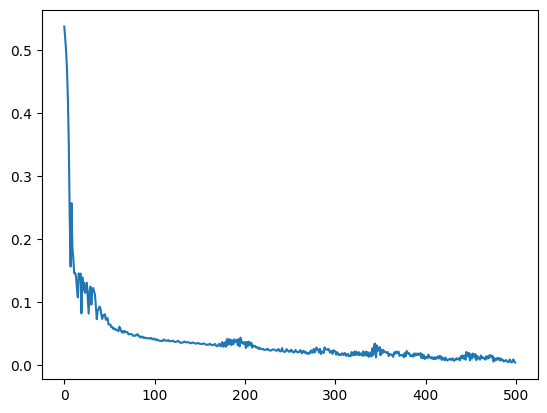

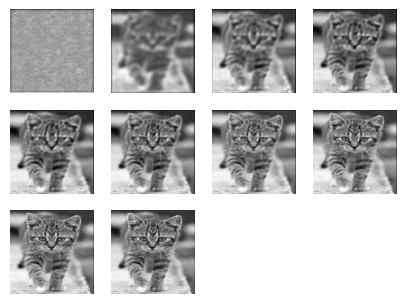

  0 / 500 loss : 0.51767
Using SSIM get: 0.004536
 50 / 500 loss : 0.05374
Using SSIM get: 0.656609
100 / 500 loss : 0.03708
Using SSIM get: 0.786829
150 / 500 loss : 0.03063
Using SSIM get: 0.838247
200 / 500 loss : 0.02634
Using SSIM get: 0.867745
250 / 500 loss : 0.02448
Using SSIM get: 0.893534
300 / 500 loss : 0.02416
Using SSIM get: 0.914578
350 / 500 loss : 0.01780
Using SSIM get: 0.929651
400 / 500 loss : 0.01543
Using SSIM get: 0.945852
450 / 500 loss : 0.01663
Using SSIM get: 0.957336


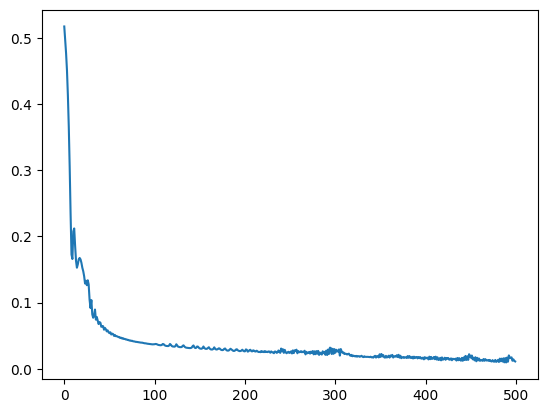

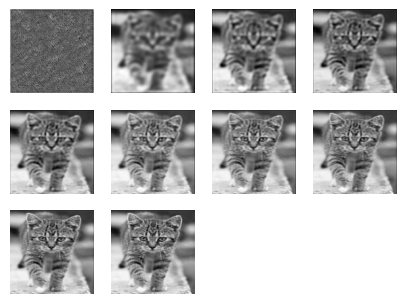

In [63]:
# 定義數據集和數據加載器
dataset = CustomImage(config.image_path)
loader = Get_DataLoader(dataset, DIP_Method=True)

# 創建並訓練第一個 DDPM 模型（使用時間步驟）
ddpm1 = DDPM(UNet(config.n_steps, config.time_n_embd, DIP_Method=True),
             n_steps=config.n_steps,
             min_beta=config.min_beta,
             max_beta=config.max_beta,
             device=config.device,
             DIP_Method=True,
             time_step=True)
optimizer1 = torch.optim.Adam(ddpm1.parameters(), lr=config.lr)
train(ddpm1, loader, config.epochs, optimizer1, device=config.device, display=True)

# 創建並訓練第二個 DDPM 模型（不使用時間步驟）
ddpm2 = DDPM(UNet(config.n_steps, config.time_n_embd, DIP_Method=True),
             n_steps=config.n_steps,
             min_beta=config.min_beta,
             max_beta=config.max_beta,
             device=config.device,
             DIP_Method=True,
             time_step=False)
optimizer2 = torch.optim.Adam(ddpm2.parameters(), lr=config.lr)
train(ddpm2, loader, config.epochs, optimizer2, device=config.device, display=True)


# 學習率對於深度動態預測模型（DDPM）的影響

Current learning rate: 0.0010
  0 / 500 loss : 0.44026
Using SSIM get: -0.050093
 50 / 500 loss : 0.06714
Using SSIM get: 0.495501
100 / 500 loss : 0.04534
Using SSIM get: 0.696795
150 / 500 loss : 0.03856
Using SSIM get: 0.747455
200 / 500 loss : 0.03611
Using SSIM get: 0.778427
250 / 500 loss : 0.03290
Using SSIM get: 0.806182
300 / 500 loss : 0.03186
Using SSIM get: 0.841176
350 / 500 loss : 0.02361
Using SSIM get: 0.888505
400 / 500 loss : 0.01771
Using SSIM get: 0.927458
450 / 500 loss : 0.01583
Using SSIM get: 0.951816
Current learning rate: 0.0030
  0 / 500 loss : 0.41550
Using SSIM get: -0.001893
 50 / 500 loss : 0.04908
Using SSIM get: 0.654732
100 / 500 loss : 0.03643
Using SSIM get: 0.758217
150 / 500 loss : 0.03125
Using SSIM get: 0.802353
200 / 500 loss : 0.02819
Using SSIM get: 0.834780
250 / 500 loss : 0.02464
Using SSIM get: 0.874790
300 / 500 loss : 0.01814
Using SSIM get: 0.915986
350 / 500 loss : 0.01220
Using SSIM get: 0.960172
400 / 500 loss : 0.01243
Using SSIM ge

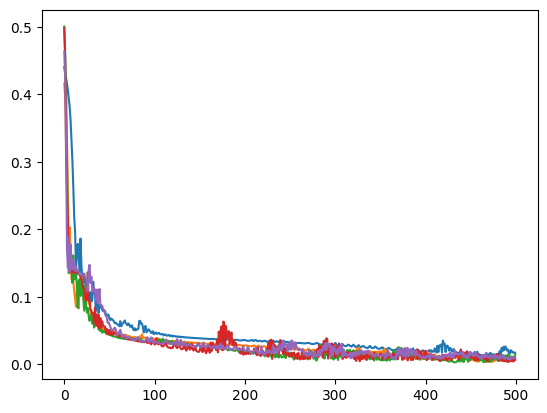

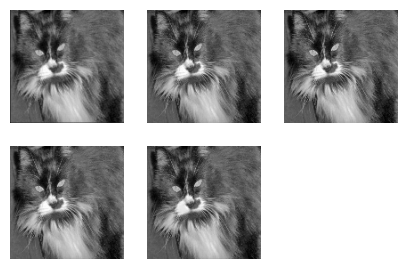

Current learning rate: 0.0010
  0 / 500 loss : 0.40583
Using SSIM get: 0.270661
 50 / 500 loss : 0.05363
Using SSIM get: 0.657574
100 / 500 loss : 0.03399
Using SSIM get: 0.777317
150 / 500 loss : 0.02804
Using SSIM get: 0.813280
200 / 500 loss : 0.02475
Using SSIM get: 0.839663
250 / 500 loss : 0.02178
Using SSIM get: 0.860040
300 / 500 loss : 0.02283
Using SSIM get: 0.881623
350 / 500 loss : 0.02138
Using SSIM get: 0.903962
400 / 500 loss : 0.01680
Using SSIM get: 0.921435
450 / 500 loss : 0.01261
Using SSIM get: 0.934486
Current learning rate: 0.0030
  0 / 500 loss : 0.57336
Using SSIM get: 0.025827
 50 / 500 loss : 0.03576
Using SSIM get: 0.761486
100 / 500 loss : 0.02781
Using SSIM get: 0.817635
150 / 500 loss : 0.02527
Using SSIM get: 0.842478
200 / 500 loss : 0.02305
Using SSIM get: 0.865477
250 / 500 loss : 0.02079
Using SSIM get: 0.888765
300 / 500 loss : 0.01911
Using SSIM get: 0.909438
350 / 500 loss : 0.01980
Using SSIM get: 0.926578
400 / 500 loss : 0.01885
Using SSIM get:

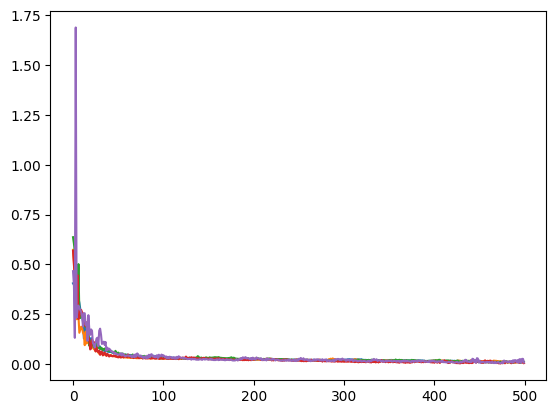

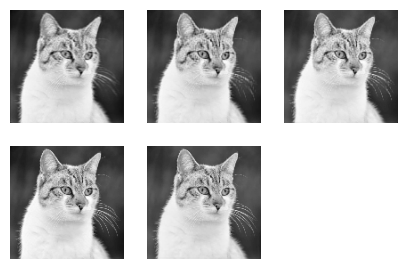

Current learning rate: 0.0010
  0 / 500 loss : 0.39873
Using SSIM get: 0.105095
 50 / 500 loss : 0.07283
Using SSIM get: 0.467633
100 / 500 loss : 0.04317
Using SSIM get: 0.637904
150 / 500 loss : 0.04253
Using SSIM get: 0.698906
200 / 500 loss : 0.03361
Using SSIM get: 0.740134
250 / 500 loss : 0.03190
Using SSIM get: 0.772180
300 / 500 loss : 0.02977
Using SSIM get: 0.811168
350 / 500 loss : 0.02562
Using SSIM get: 0.857954
400 / 500 loss : 0.01894
Using SSIM get: 0.901482
450 / 500 loss : 0.01471
Using SSIM get: 0.938033
Current learning rate: 0.0030
  0 / 500 loss : 0.41242
Using SSIM get: 0.134296
 50 / 500 loss : 0.05134
Using SSIM get: 0.595404
100 / 500 loss : 0.03452
Using SSIM get: 0.736774
150 / 500 loss : 0.03037
Using SSIM get: 0.820416
200 / 500 loss : 0.02637
Using SSIM get: 0.898470
250 / 500 loss : 0.01686
Using SSIM get: 0.949063
300 / 500 loss : 0.01166
Using SSIM get: 0.978857
350 / 500 loss : 0.00784
Using SSIM get: 0.991976
400 / 500 loss : 0.00858
Using SSIM get:

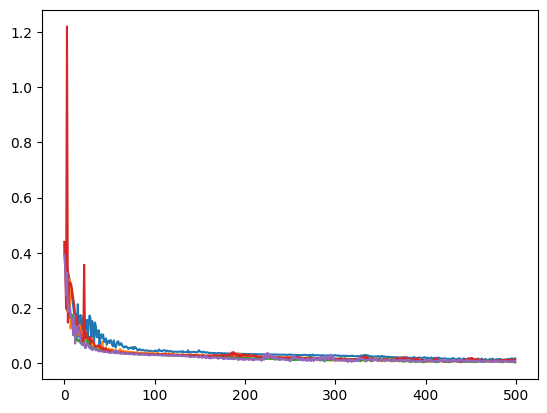

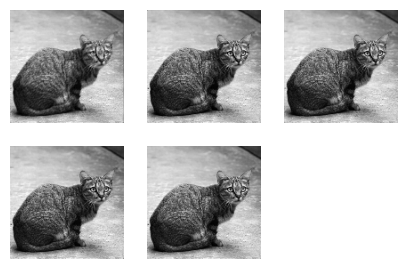

Current learning rate: 0.0010
  0 / 500 loss : 0.49922
Using SSIM get: 0.024026
 50 / 500 loss : 0.06959
Using SSIM get: 0.576859
100 / 500 loss : 0.03888
Using SSIM get: 0.804657
150 / 500 loss : 0.03201
Using SSIM get: 0.857321
200 / 500 loss : 0.02947
Using SSIM get: 0.882611
250 / 500 loss : 0.02570
Using SSIM get: 0.901291
300 / 500 loss : 0.02399
Using SSIM get: 0.916348
350 / 500 loss : 0.02104
Using SSIM get: 0.929285
400 / 500 loss : 0.02394
Using SSIM get: 0.940389
450 / 500 loss : 0.01708
Using SSIM get: 0.951352
Current learning rate: 0.0030
  0 / 500 loss : 0.43478
Using SSIM get: 0.100649
 50 / 500 loss : 0.03642
Using SSIM get: 0.812694
100 / 500 loss : 0.02290
Using SSIM get: 0.911367
150 / 500 loss : 0.01745
Using SSIM get: 0.947459
200 / 500 loss : 0.02088
Using SSIM get: 0.964865
250 / 500 loss : 0.01142
Using SSIM get: 0.975750
300 / 500 loss : 0.01020
Using SSIM get: 0.983952
350 / 500 loss : 0.01133
Using SSIM get: 0.988473
400 / 500 loss : 0.00872
Using SSIM get:

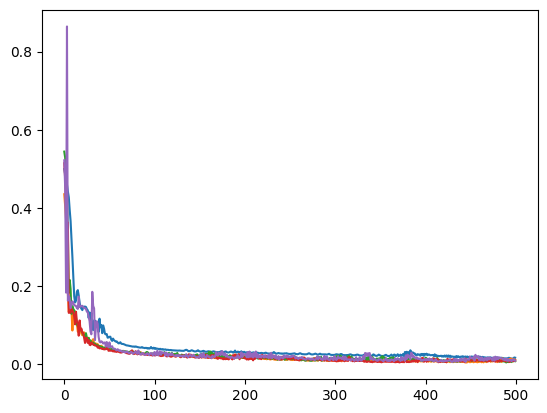

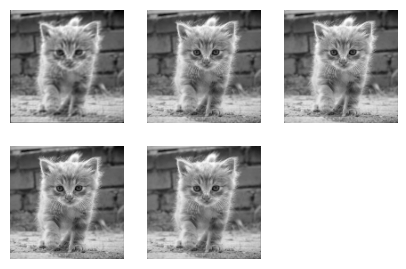

Current learning rate: 0.0010
  0 / 500 loss : 0.55815
Using SSIM get: -0.041135
 50 / 500 loss : 0.10024
Using SSIM get: 0.408944
100 / 500 loss : 0.05468
Using SSIM get: 0.629264
150 / 500 loss : 0.04645
Using SSIM get: 0.683174
200 / 500 loss : 0.04271
Using SSIM get: 0.733849
250 / 500 loss : 0.03734
Using SSIM get: 0.786749
300 / 500 loss : 0.03009
Using SSIM get: 0.835882
350 / 500 loss : 0.02421
Using SSIM get: 0.874645
400 / 500 loss : 0.01938
Using SSIM get: 0.909845
450 / 500 loss : 0.01458
Using SSIM get: 0.942320
Current learning rate: 0.0030
  0 / 500 loss : 0.43230
Using SSIM get: 0.115124
 50 / 500 loss : 0.05766
Using SSIM get: 0.558233
100 / 500 loss : 0.04599
Using SSIM get: 0.705673
150 / 500 loss : 0.04072
Using SSIM get: 0.782047
200 / 500 loss : 0.03346
Using SSIM get: 0.840298
250 / 500 loss : 0.02438
Using SSIM get: 0.893433
300 / 500 loss : 0.01871
Using SSIM get: 0.941436
350 / 500 loss : 0.01378
Using SSIM get: 0.963970
400 / 500 loss : 0.01265
Using SSIM get

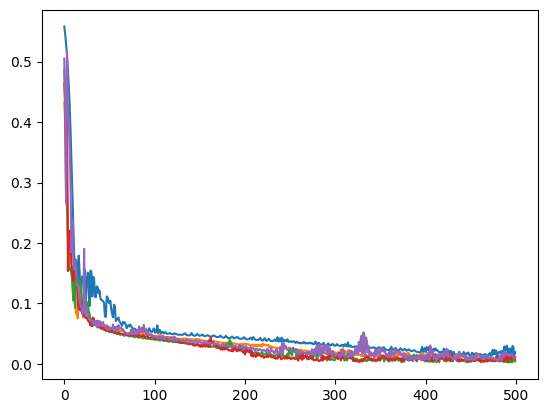

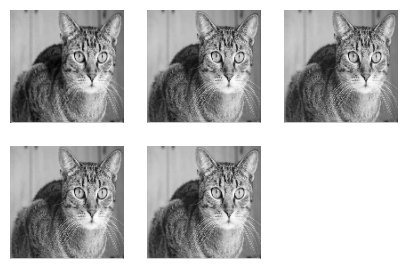

Current learning rate: 0.0010
  0 / 500 loss : 0.45007
Using SSIM get: 0.115342
 50 / 500 loss : 0.09084
Using SSIM get: 0.477764
100 / 500 loss : 0.05733
Using SSIM get: 0.707228
150 / 500 loss : 0.04415
Using SSIM get: 0.827373
200 / 500 loss : 0.03672
Using SSIM get: 0.866042
250 / 500 loss : 0.03218
Using SSIM get: 0.889218
300 / 500 loss : 0.02927
Using SSIM get: 0.903130
350 / 500 loss : 0.02724
Using SSIM get: 0.913957
400 / 500 loss : 0.02439
Using SSIM get: 0.921562
450 / 500 loss : 0.02275
Using SSIM get: 0.929652
Current learning rate: 0.0030
  0 / 500 loss : 0.54531
Using SSIM get: 0.028657
 50 / 500 loss : 0.06928
Using SSIM get: 0.633951
100 / 500 loss : 0.04040
Using SSIM get: 0.834260
150 / 500 loss : 0.03231
Using SSIM get: 0.883299
200 / 500 loss : 0.02931
Using SSIM get: 0.908947
250 / 500 loss : 0.02560
Using SSIM get: 0.931344
300 / 500 loss : 0.01651
Using SSIM get: 0.954832
350 / 500 loss : 0.01393
Using SSIM get: 0.966209
400 / 500 loss : 0.01243
Using SSIM get:

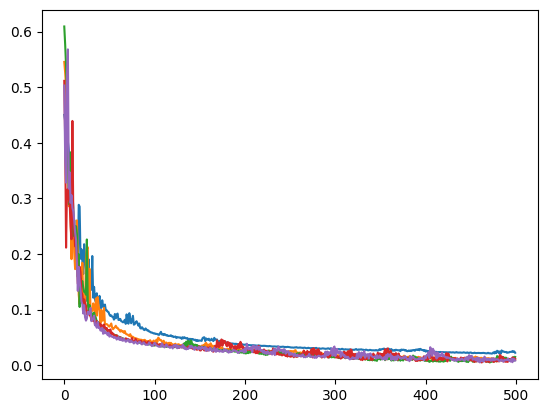

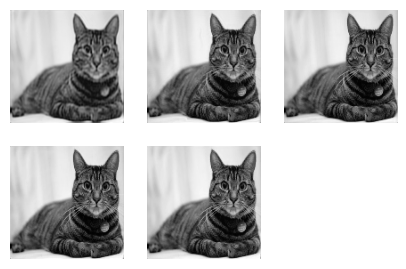

Current learning rate: 0.0010
  0 / 500 loss : 0.19229
Using SSIM get: 0.164860
 50 / 500 loss : 0.04961
Using SSIM get: 0.534192
100 / 500 loss : 0.03502
Using SSIM get: 0.712085
150 / 500 loss : 0.02671
Using SSIM get: 0.811672
200 / 500 loss : 0.01779
Using SSIM get: 0.898061
250 / 500 loss : 0.01236
Using SSIM get: 0.957286
300 / 500 loss : 0.00803
Using SSIM get: 0.988999
350 / 500 loss : 0.00468
Using SSIM get: 0.997214
400 / 500 loss : 0.00709
Using SSIM get: 0.997126
450 / 500 loss : 0.00366
Using SSIM get: 0.998959
Current learning rate: 0.0030
  0 / 500 loss : 0.28722
Using SSIM get: 0.058475
 50 / 500 loss : 0.04858
Using SSIM get: 0.579313
100 / 500 loss : 0.03129
Using SSIM get: 0.775414
150 / 500 loss : 0.02134
Using SSIM get: 0.881756
200 / 500 loss : 0.01301
Using SSIM get: 0.969422
250 / 500 loss : 0.01123
Using SSIM get: 0.993345
300 / 500 loss : 0.00606
Using SSIM get: 0.998416
350 / 500 loss : 0.00526
Using SSIM get: 0.998842
400 / 500 loss : 0.00580
Using SSIM get:

In [ ]:
learning_rate = np.arange(0.001, 0.011, 0.002)
average_dict = {lr: [] for lr in learning_rate}

for _ in range(10):
    dataset = CustomImage(config.image_path)
    loader = Get_DataLoader(dataset, DIP_Method=True)

    ddpms = []
    for lr in learning_rate:
        print(f'Current learning rate: {lr:.4f}')
        ddpm = DDPM(UNet(config.n_steps, config.time_n_embd, DIP_Method=True),
                    n_steps=config.n_steps,
                    min_beta=config.min_beta,
                    max_beta=config.max_beta,
                    device=config.device,
                    DIP_Method=True,
                    time_step=True)
        optimizer = torch.optim.Adam(ddpm.parameters(), lr)
        train(ddpm, loader, config.epochs, optimizer, device=config.device, display=False)
        ddpms.append(ddpm)

    eval_lr(ddpms, learning_rate, next(iter(loader)), average_dict)

for lr, ssim_list in average_dict.items():
    avg_ssim = statistics.mean(ssim_list)
    print(f'Learning rate: {lr:.4f}, Average SSIM: {avg_ssim:.6f}')